In [1]:
%config Completer.use_jedi = False

In [52]:
import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.utils import Sequence

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import pandas as pd
import numpy as np
import os
import shutil
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Data Preparation

In [3]:
base = 'dataset'
base_resnet = os.path.join(base, 'ResNet')
base_output = os.path.join('output', 'ResNet')

dataset_types = ['train', 'test', 'validate']
categorys = ['cancer', 'pmd', 'normal']

In [4]:
if not os.path.exists(base_resnet):
    os.makedirs(base_resnet, exist_ok=True)
if not os.path.exists(base_output):
    os.makedirs(base_output, exist_ok=True)

In [5]:
datasets = {dataset_type:[] for dataset_type in dataset_types}
for category in categorys:
    df = pd.read_json(os.path.join(base, 'dataset_{}_augment.json'.format(category)))
    for dataset_type in dataset_types:
        datasets[dataset_type].append(df[df['type']==dataset_type])

for dataset_type in datasets:
    df = pd.concat(datasets[dataset_type])
    df['file_name'] = base+"/image/"+df['category']+"/"+df['file_name']
    datasets[dataset_type] = df

# Hyperparameters

In [6]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32

LR = 1e-5 # Learning rate

In [45]:
'''
    note
    
    old : train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')
'''
train_aug = ImageDataGenerator(rescale=1./255)
val_aug   = ImageDataGenerator(rescale=1./255)
test_aug  = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(datasets['train'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='sparse') 

val_generator = val_aug.flow_from_dataframe(datasets['validate'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='sparse') 

test_generator = test_aug.flow_from_dataframe(datasets['test'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=1, 
                                                shuffle=False,
                                                class_mode='sparse')

Found 1360 validated image filenames belonging to 3 classes.
Found 196 validated image filenames belonging to 3 classes.
Found 392 validated image filenames belonging to 3 classes.


In [8]:
def build_model_ResNet101(target_size=(224,224), n_class=None):
    if n_class is None:
        raise Exception('Please input n_class | number of classes')
    IMG_WIDTH, IMG_HEIGHT = target_size
    NUM_CLASSES = n_class
    base_model = keras.applications.ResNet101(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
    
    average_pooling_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
    average_pooling_layer = keras.layers.Dropout(0.5)(average_pooling_layer)
    
    prediction_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(average_pooling_layer)
    model = keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    return model

In [9]:
tf.compat.v1.disable_eager_execution()
os.environ['CUDA_VISIBLE_DEVICES']="0"
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU':16}) 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [10]:
model = build_model_ResNet101(target_size=(IMG_WIDTH, IMG_HEIGHT), n_class=len(train_generator.class_indices))
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv

In [11]:
model.compile(optimizer=Adam(LR), 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [12]:
model_name = "ResNet101_research03"
model_path = os.path.join(base_output, "{}.h5".format(model_name))

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')
reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

In [13]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
43/43 [==============================] - 64s 1s/step - loss: 1.0872 - sparse_categorical_accuracy: 0.5131 - val_loss: 0.7620 - val_sparse_categorical_accuracy: 0.6480
Epoch 2/100
43/43 [==============================] - 44s 1s/step - loss: 0.4922 - sparse_categorical_accuracy: 0.7907 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.7755
Epoch 3/100
43/43 [==============================] - 56s 1s/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.3993 - val_sparse_categorical_accuracy: 0.8112
Epoch 4/100
43/43 [==============================] - 57s 1s/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.3085 - val_sparse_categorical_accuracy: 0.8878
Epoch 5/100
43/43 [==============================] - 56s 1s/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.2553 - val_sparse_categorical_accuracy: 0.9082
Epoch 6/100

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'loss', 'sparse_categorical_accuracy', 'lr'])

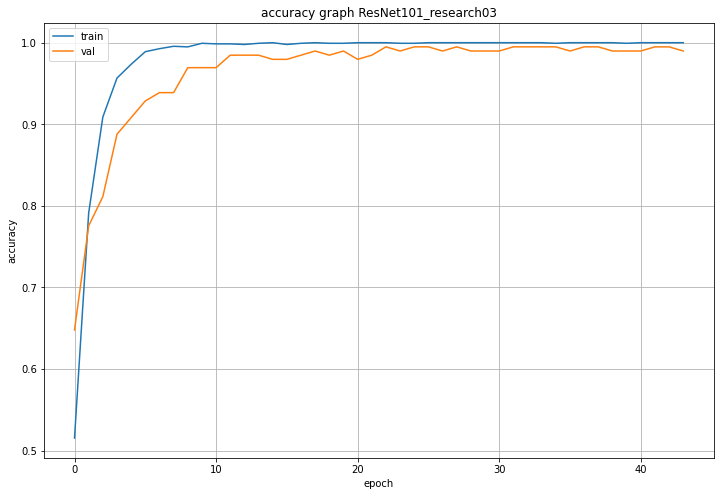

In [24]:
plt.figure(figsize=(12,8))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy graph {}'.format(model_name))
plt.grid()
plt.savefig(os.path.join(base_output, 'train_accuracy_{}'.format(model_name)))
plt.show()

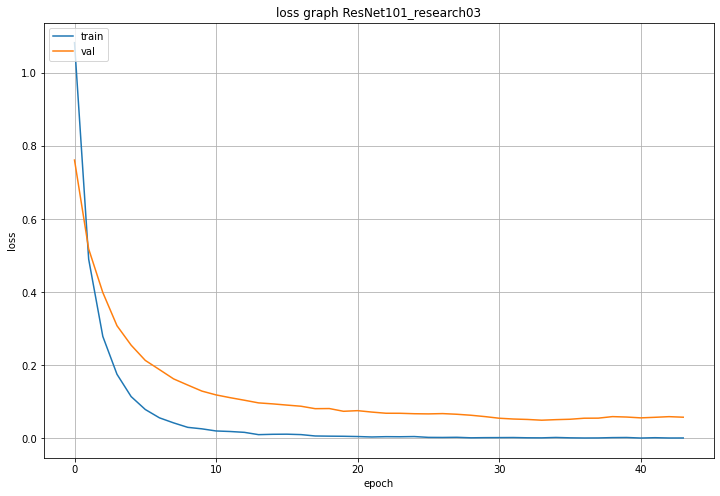

In [25]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss graph {}'.format(model_name))
plt.grid()
plt.savefig(os.path.join(base_output, 'train_loss_{}'.format(model_name)))
plt.show()

In [26]:
model_name = "ResNet101_research03"
model_path = os.path.join(base_output, "{}.h5".format(model_name))

test_model = tf.keras.models.load_model(model_path)

In [27]:
num_test_files = len(test_generator.filenames)
test_generator.reset()

In [47]:
test_labels = test_generator.labels
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

In [51]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))


array([[132,   0,  12],
       [  1, 117,   2],
       [  5,   4, 119]])

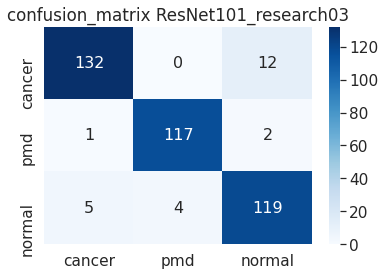

In [67]:
plt.title('confusion_matrix {}'.format(model_name))
df_cm = pd.DataFrame(cm, categorys, categorys)
sns.set(font_scale=1.4)
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")
fig.figure.savefig(os.path.join(base_output, 'confusion_matrix_{}.png'.format(model_name)))

In [69]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=categorys))

Confusion Matrix
[[132   0  12]
 [  1 117   2]
 [  5   4 119]]
Classification Report
              precision    recall  f1-score   support

      cancer       0.96      0.92      0.94       144
         pmd       0.97      0.97      0.97       120
      normal       0.89      0.93      0.91       128

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392

